## Hubway Network Analysis

This file reads __All__ of the Hubway data into a MultiGraph so we can do Network Analysis. 
Nodes/Edges contain all properties we have, which will be useful later. 

In [1]:
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
station_file = open('data/hubway_stations.csv', 'r')
station_data = [line.split(",") for line in station_file.read().split("\r\n")]

keys = station_data[0]
station_data = station_data[1:]

# Create a map of {id: {attribute: val}}
nodes = {}
for row in station_data:
    id = row[0]
    if not id:
        continue
    if id not in nodes:
        nodes[id] = {}
    j = 1
    for k in keys[1:]:
        nodes[id][k] = row[j]
        j += 1

### Read in Trips Data

Assuming you unzipped the files in their raw form into a folder called "data", 
this creates a new file called edges.txt that contains the format we need to use the
NetworkX importer tool. 


In [3]:
trip_file = open('data/hubway_trips.csv', 'r')

keys = [k.strip() for k in trip_file.readline().split(",")]

# Edges is a list of {(start, end): {attribute: val}}
edges = {}
f = open('data/edges.txt', 'w')
for line in trip_file:
    attributes = {}
    line = line.split(",")
    
    if line[0] is None:
        continue

    # Remove that weird extra ' in Column 10
    line[10] = line[10][1:]

    start_station = line[5]
    end_station = line[7]
    
    if not start_station or not end_station:
        continue
    
    key = (int(start_station), int(end_station))
    
    if key not in edges:
        edges[key] = {}
    
    j = 0
    for k in keys:
        attributes[k] = line[j].strip()
        j += 1

    f.write("{} {} {}\n".format(key[0], key[1], str(attributes)))

f.close()

### Create Graph

Read in Edges into MultiGraph. Need MultiGraph because each set of two hubway station could have
thousands of rides between them.

This will take a few minutes, and be pretty memory heavy. 

In [4]:
G_total = nx.read_edgelist('./data/edges.txt', comments='#',
                     create_using=nx.MultiGraph(), 
                     delimiter=' ', 
                     nodetype=int, 
                     encoding='utf-8')

In [5]:
# Add attributes to node object

for key in nodes:
    G_total.node[int(key)] = nodes[key]

Get every trip between a specified START_DAY and END_DAY.

In [6]:
import time

START_DAY = time.strptime("1/01/13", "%m/%d/%y")
END_DAY = time.strptime("12/31/13", "%m/%d/%y")

def select(G2, query):
    '''Call the query for each edge, return list of matches'''
    result = []
    for u,v,d in G2.edges(data=True):
        if query(u,v,d):
            result.append((u,v,d))
    return result

def date_range(u,v,d):
    start = time.strptime(d['start_date'], '%m/%d/%Y %H:%M:%S')
    end = time.strptime(d['end_date'], '%m/%d/%Y %H:%M:%S')
    return start > START_DAY and end < END_DAY

edges = select(G_total, date_range)

## Unweighted Multigraph

Use this filtered edge list to recreate a MultiGraph, this time just for our date range.

In [7]:
G = nx.MultiGraph(edges)

# Add node data
for key in nodes:
    G.node[int(key)] = nodes[key]

In [8]:
print "Number of Nodes: ", G.number_of_nodes()
print "Number of Edges: ", G.number_of_edges()

Number of Nodes:  142
Number of Edges:  904675


In [9]:
N = G.number_of_nodes()
L = G.number_of_edges()
degrees = G.degree().values()
kmin = min(degrees)
kmax = max(degrees)

print "Number of nodes: ", N
print "Number of edges: ", L
print
print "Average degree: ", 2.0*L/N
print
print "Minimum degree: ", kmin
print "Maximum degree: ", kmax
print
# Cant calculate average shortest path because graph is not connected
# print "Average Shortest Path", nx.average_shortest_path_length(G)

Number of nodes:  142
Number of edges:  904675

Average degree:  12741.9014085

Minimum degree:  91
Maximum degree:  53795



## Degree Distribution

Plotting the Degree distribution on a log-log scale to see if it fits a Power Law Distribution.

This assumption will be checked more thoroughly below.

In [10]:
bin_edges = np.logspace(np.log10(kmin), np.log10(kmax), num=20)
density, _ = np.histogram(degrees, bins=bin_edges, density=True)

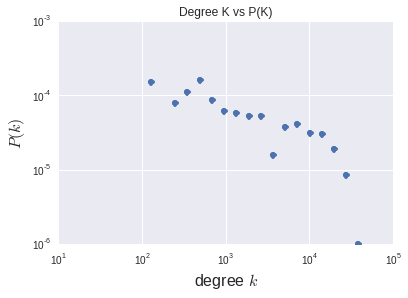

In [11]:
%matplotlib inline
fig = plt.figure(figsize=(6,4))
plt.loglog(bin_edges[:-1], density, marker='o', linestyle='none')
plt.xlabel(r"degree $k$", fontsize=16)
plt.ylabel(r"$P(k)$", fontsize=16)
plt.title("Degree K vs P(K)")
plt.show()

### Most and Least used Stations

In [12]:
import operator
sorted_degrees = sorted(G.degree().items(), key=operator.itemgetter(1))

n = len(sorted_degrees)
print "Top 5 used stations"
print "-------------------"
for i in reversed(range(n - 5, n)):
    node_id = sorted_degrees[i][0]
    degree = sorted_degrees[i][1]
    print "Node: {}, Degree: {}, Attributes: {}".format(node_id, degree, G.node[node_id])

print
print
print "Top 5 Least used stations"
print "-------------------------"
for i in range(0, 5):
    node_id = sorted_degrees[i][0]
    degree = sorted_degrees[i][1]
    print "Node: {}, Degree: {}, Attributes: {}".format(node_id, degree, G.node[node_id])

Top 5 used stations
-------------------
Node: 67, Degree: 53795, Attributes: {'status': 'Existing', 'municipal': 'Cambridge', 'terminal': 'M32006', 'station': 'MIT at Mass Ave / Amherst St', 'lat': '42.3581', 'lng': '-71.093198'}
Node: 22, Degree: 51090, Attributes: {'status': 'Existing', 'municipal': 'Boston', 'terminal': 'A32010', 'station': 'South Station - 700 Atlantic Ave.', 'lat': '42.352175', 'lng': '-71.055547'}
Node: 113, Degree: 39634, Attributes: {'status': 'Existing', 'municipal': 'Boston', 'terminal': 'D32016', 'station': 'Charles Circle - Charles St. at Cambridge St.', 'lat': '42.36069', 'lng': '-71.070884'}
Node: 74, Degree: 38407, Attributes: {'status': 'Existing', 'municipal': 'Cambridge', 'terminal': 'M32018', 'station': 'Harvard Square at Mass Ave/ Dunster', 'lat': '42.373268', 'lng': '-71.118579'}
Node: 53, Degree: 38103, Attributes: {'status': 'Existing', 'municipal': 'Boston', 'terminal': 'B32016', 'station': 'Beacon St / Mass Ave', 'lat': '42.350851', 'lng': '-71

## Weighted Graph

Transform this into a weighted graph for easier analysis and less memory usage.

In [13]:
def get_weighted(Old):
    N = nx.Graph()
    for u,v,data in Old.edges_iter(data=True):
        if N.has_edge(u, v):
            N[u][v]['weight'] += 1
        else:
            N.add_edge(u, v, weight=1)
    return N

G_w = get_weighted(G)


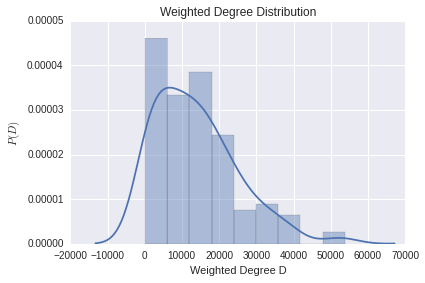

In [14]:
sns.distplot(G_w.degree(weight='weight').values())
plt.title("Weighted Degree Distribution")
plt.xlabel("Weighted Degree D")
plt.ylabel(r"$P(D)$")

The above weighted degree distribution shows the distribution of the number of rides (degree) of a given station.

Below, we re-output some basic data to verify that the unweighted-weighted conversion worked correctly.

In [15]:
N = G_w.number_of_nodes()
L = G_w.number_of_edges()
degrees = G_w.degree(weight='weight').values()
kmin = min(degrees)
kmax = max(degrees)

print "Number of nodes: ", N
print "Number of edges: ", L
print
print "Average degree: ", float(sum(degrees)) / len(degrees)
print
print "Minimum degree: ", kmin
print "Maximum degree: ", kmax
print
# Cant calculate average shortest path because graph is not connected
# print "Average Shortest Path", nx.average_shortest_path_length(G)

Number of nodes:  131
Number of edges:  7269

Average degree:  13811.8320611

Minimum degree:  91
Maximum degree:  53795



## Weighted Degree Distribution

This distribution should be the exact same as above. Just replotting cause its pretty. 

In [16]:
bin_edges = np.logspace(np.log10(kmin), np.log10(kmax), num=40)
density, _ = np.histogram(degrees, bins=bin_edges, density=True)

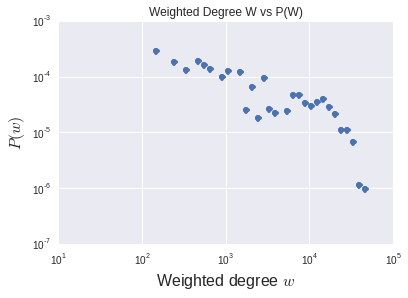

In [17]:
%matplotlib inline
fig = plt.figure(figsize=(6,4))
plt.loglog(bin_edges[:-1], density, marker='o', linestyle='none')
plt.xlabel(r"Weighted degree $w$", fontsize=16)
plt.ylabel(r"$P(w)$", fontsize=16)
plt.title("Weighted Degree W vs P(W)")
plt.show()

### Fit Power law

Use the [Kolmogorov-Smirnov 2 Sample Test](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test) verify that this is in fact a power law. We attempt to fit a powerlaw to the data, and check that the degree distributions are ballpark near eachother.

In [18]:
import powerlaw
import scipy

def fit_powerlaw(deg):
    p = powerlaw.Fit(deg, discrete=True)
    powerfit = powerlaw.Power_Law(xmin=p.xmin)
    powerfit.fit(deg)
    theoretical = powerfit.generate_random(len(deg))
    ks = scipy.stats.ks_2samp(deg[deg > p.xmin], theoretical)
    return {'alpha': p.alpha, 'xmin': p.xmin, 'pval': ks[1]}

In [19]:
pvals = []

for _ in xrange(1):
    pvals.append(fit_powerlaw(np.array(degrees))['pval'])

print "Average P: {}".format( sum(pvals) / len(pvals))

Average P: 0.135446176406


Calculating best minimal value for power law fit


#### Powerlaw fit

Our Null Hypothesis is that this is a Power law, and a P value of 0.36 is not significant enough to reject this null hypothesis. 


## Distance Calculations

We used geospatial data between hubs to find the shortest __road__ distance between any two stations. This data is stored in the data/distances.csv file.

In [20]:
f = open('data/distances.csv')

dist = f.read().split("\r\n")
header = dist[0]
dist = dist[1:]
dist = [d.split(",") for d in dist]


In [22]:
print header

ObjectID,Name,OriginID,DestinationID,DestinationRank,Total_Miles


In [23]:
distances = {}

for d in dist:
    if len(d) < 5:
        break
    key = (int(d[-4]), int(d[-3]))
    distances[key] = float(d[-1])

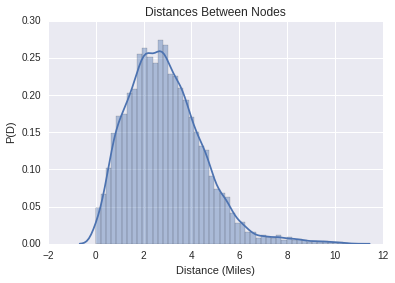

In [24]:
d = np.array(distances.values())
%matplotlib inline
sns.distplot(d)
plt.title("Distances Between Nodes")
plt.xlabel("Distance (Miles)")
plt.ylabel("P(D)")

Above we have the distribution of distances between any two stations.

In [27]:
print "Mean Distance between nodes: %0.3f miles" % d.mean()

Mean Distance between nodes: 2.892 miles


In [28]:
for e in G_w.edges_iter():
    if e not in distances:
        # print "Not found: {}".format(e)
        d = 8
    else:
        d = distances[e]
    G_w[e[0]][e[1]]['distance'] = d

In [29]:
degree_dict = dict(sorted_degrees)

d_min = min(degree_dict.values())
d_max = max(degree_dict.values())

def norm(x):
    return (float(x) - d_min) / (d_max - d_min)

size_dict = {}

for k in degree_dict:
    size_dict[k] = max(10, 500 * norm(degree_dict[k]))

## Visualizations

### Distance Based Layout

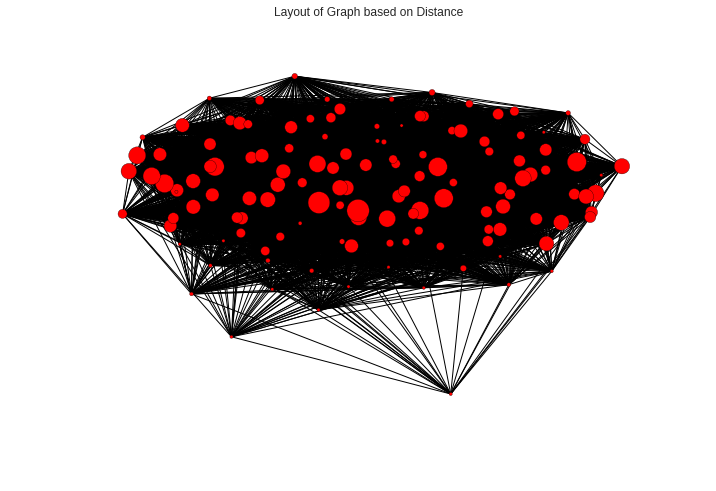

In [34]:
%matplotlib inline
pos = nx.spring_layout(G_w, weight='distance')
plt.figure(figsize=(12,8))
plt.title("Layout of Graph based on Distance")
nx.draw_networkx_edges(G_w, pos=pos)
nx.draw_networkx_nodes(G_w, pos=pos, node_size=size_dict.values())

limits = plt.axis('off')

### Weight based Layout 

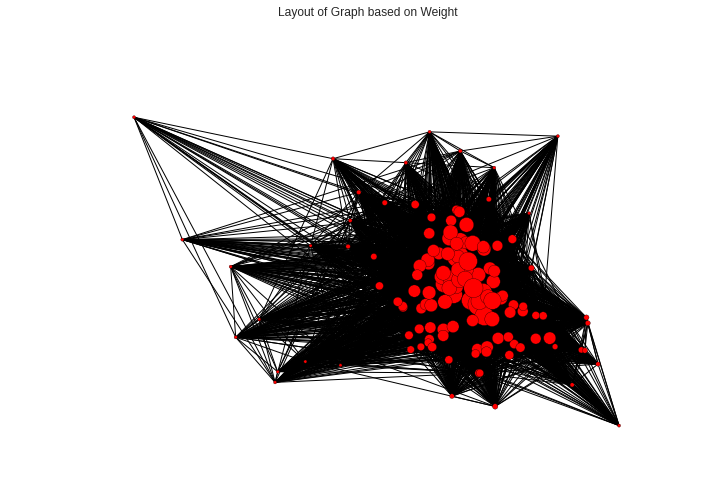

In [35]:
%matplotlib inline
pos = nx.spring_layout(G_w, weight='weight')
plt.figure(figsize=(12,8))
plt.title("Layout of Graph based on Weight")
nx.draw_networkx_edges(G_w, pos=pos)
nx.draw_networkx_nodes(G_w, pos=pos, node_size=size_dict.values())

limits = plt.axis('off')

## Modularity

We use [Network Modularity](https://en.wikipedia.org/wiki/Modularity_(networks) to find communities inside our Network Structure. 

### Distance/Spatially Weighted Modularity 

In [36]:
import community

In [37]:
# Hack around the fact that best_partition just searches for weight='weight', and doesn't let us specify.
# Make temp graph that has weight = distance...

D = G_w.copy()
for e in D.edges_iter():
    D[e[0]][e[1]]['weight'] = D[e[0]][e[1]]['distance']

for n in [63, 143, 144, 145]:
    D.remove_node(n)

In [38]:
partition = community.best_partition(D)

In [40]:
groups = {}
for k, v in partition.iteritems():
    if v in groups:
        groups[v].append(k)
    else:
        groups[v] = [k]
        
print "We found %i groups" % len(groups)

We found 3 groups


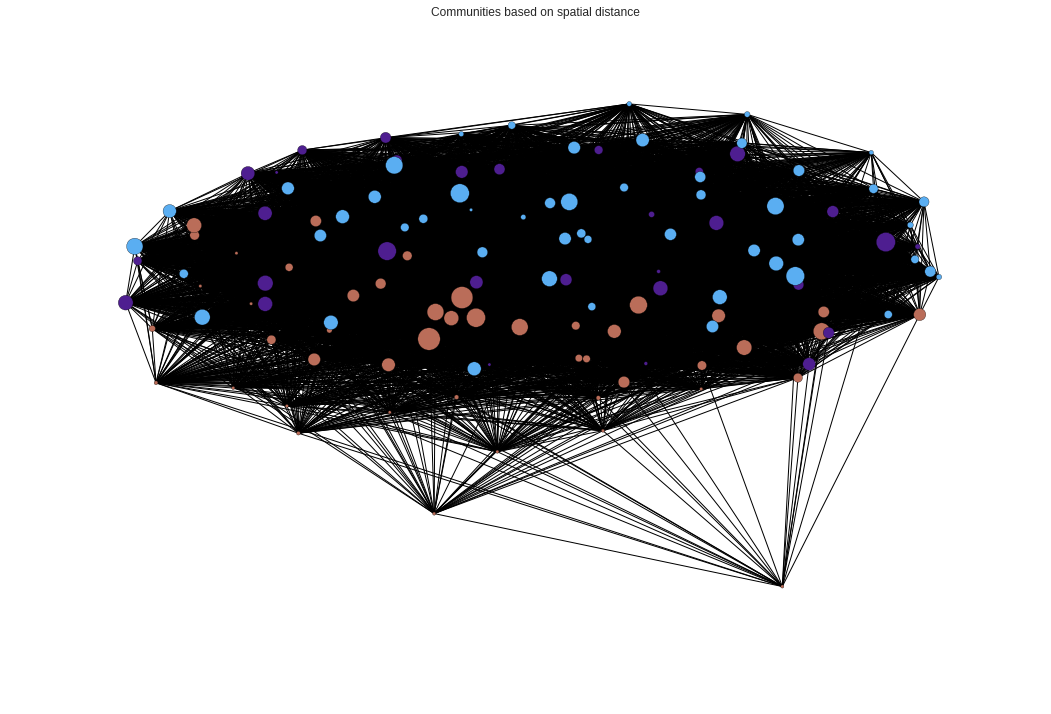

In [42]:
%matplotlib inline

colors = ['r', 'g', 'b']

pos = nx.spring_layout(D, weight='distance')
plt.figure(figsize=(18,12))
nx.draw_networkx_edges(D, pos=pos)
for i, group in enumerate(groups):
    sizes = [size_dict[x] for x in groups[group]]
    nx.draw_networkx_nodes(D, pos=pos, nodelist=groups[group], 
                     node_color=np.random.rand(3, 1), node_size=sizes)

limits = plt.axis('off')
plt.title("Communities based on spatial distance")

### Weighted Graph Community Detection

In [43]:
partition = community.best_partition(G_w)

In [44]:
groups = {}
for k, v in partition.iteritems():
    if v in groups:
        groups[v].append(k)
    else:
        groups[v] = [k]

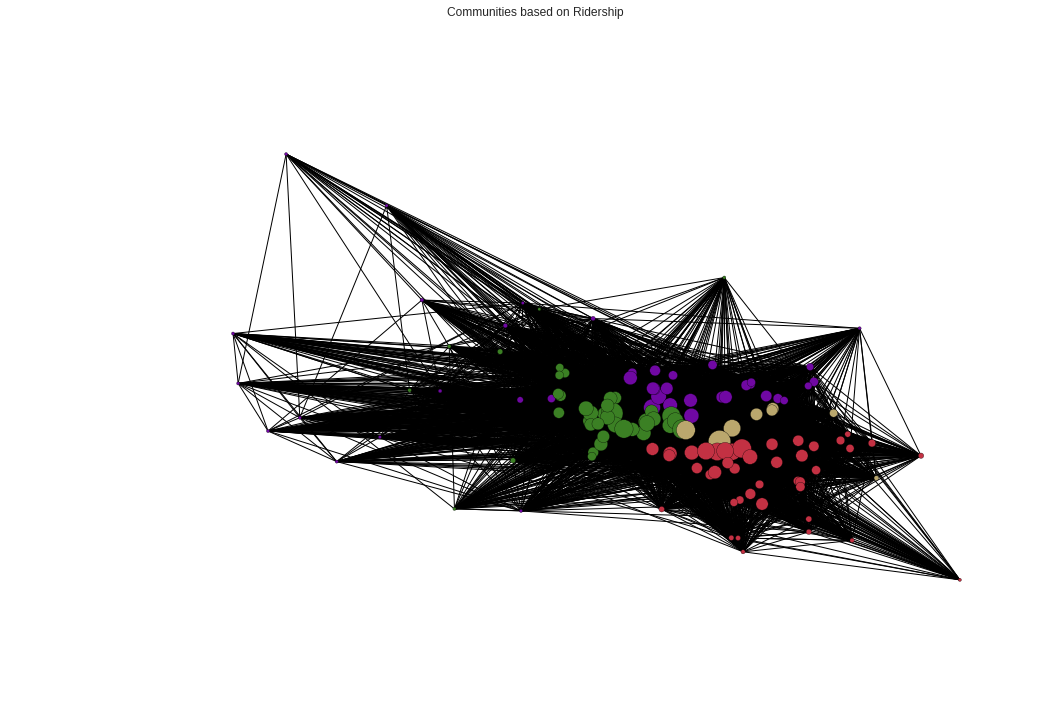

In [45]:
%matplotlib inline

pos = nx.spring_layout(G_w)
plt.figure(figsize=(18,12))
nx.draw_networkx_edges(G_w, pos=pos)
for i, group in enumerate(groups):
    sizes = [size_dict[x] for x in groups[group] if x in size_dict]
    nx.draw_networkx_nodes(G_w, pos=pos, nodelist=groups[group], 
                     node_color=np.random.rand(3, 1), node_size=sizes)

limits = plt.axis('off')
plt.title("Communities based on Ridership")

## Network Robustness

Network Robustness is a Networks resistance to different forms of attacks on nodes (stations). Each of these attacks uses a different targeting mechanism (how we decide what station to remove) to see how the network structure responds. 

Think of this like how to decide what websites to DDOS before the internet falls apart.

#### Weighted Clustering Coefficient

In [46]:
R = G_w.copy()

coeff = nx.clustering(R)
max_node_id = max(coeff, key=coeff.get)
giant_len = len(max(nx.connected_components(R), key=len))

giant_lens = [giant_len]

coeff = nx.clustering(R, weight='weight')

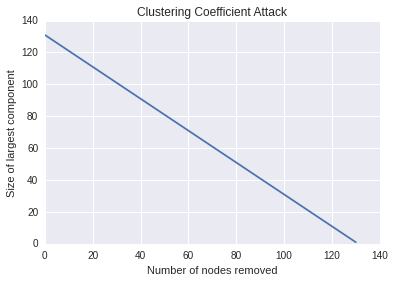

In [47]:
while(True):
    coeff = nx.clustering(R, weight='weight')
    max_node_id = max(coeff, key=coeff.get)
    R.remove_node(max_node_id)
    # del coeff[max_node_id]
    
    if len(R.nodes()) <= 0:
        break
    
    conn = nx.connected_components(R)
    giant_len = len(max(conn, key=len))
    giant_lens.append(giant_len)

%matplotlib inline
plt.plot(range(0, len(giant_lens)), giant_lens)
plt.title("Clustering Coefficient Attack")
plt.xlabel("Number of nodes removed")
plt.ylabel("Size of largest component")

#### Weighted Degree Attack

In [48]:
R = G_w.copy()


giant_len = len(max(nx.connected_components(R), key=len))
giant_lens = [giant_len]

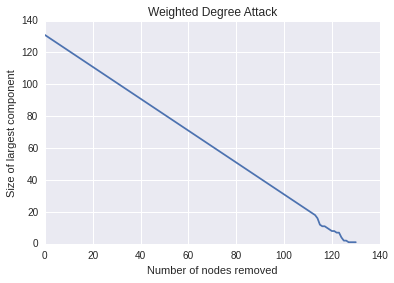

In [49]:
while(True):
    degrees = R.degree(weight='weight')
    max_node_id = max(degrees, key=degrees.get)
    R.remove_node(max_node_id)
    
    if len(R.nodes()) <= 0:
        break
    
    conn = nx.connected_components(R)
    giant_len = len(max(conn, key=len))
    giant_lens.append(giant_len)

%matplotlib inline
plt.plot(range(0, len(giant_lens)), giant_lens)
plt.title("Weighted Degree Attack")
plt.xlabel("Number of nodes removed")
plt.ylabel("Size of largest component")

Both weighted degree and clustering coefficient seemed horrible at dismantling the transportation network. Though these may be bad targeting criterion, its pretty reasonable to assume the network is robust enough that any limited number of removals of stations would not severly disrupt usage.

## Clustering Coefficient Distribution

In [50]:
coeff = nx.clustering(G_w, weight='weight')
degree = G_w.degree(weight='weight')

X = degree.values()
Y = coeff.values()

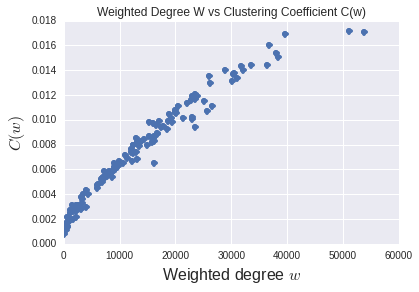

In [51]:
%matplotlib inline
fig = plt.figure(figsize=(6,4))
plt.plot(X, Y, marker='o', linestyle='none')
plt.xlabel(r"Weighted degree $w$", fontsize=16)
plt.ylabel(r"$C(w)$", fontsize=16)
plt.title("Weighted Degree W vs Clustering Coefficient C(w)")
plt.show()

## Closeness Centrality

#### Weighted by weight

In [52]:
cent_w = nx.closeness_centrality(G_w, distance='weight')

In [53]:
X = G_w.degree(weight='weight').values()
Y = cent_w.values()

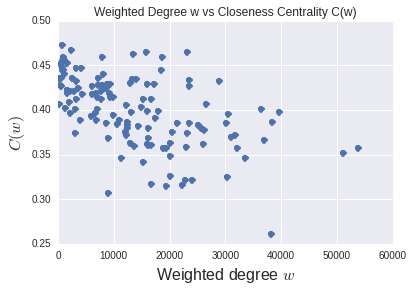

In [54]:
%matplotlib inline
fig = plt.figure(figsize=(6,4))
plt.plot(X, Y, marker='o', linestyle='none')
plt.xlabel(r"Weighted degree $w$", fontsize=16)
plt.ylabel(r"$C(w)$", fontsize=16)
plt.title("Weighted Degree w vs Closeness Centrality C(w)")
plt.show()

## Spatial Centrality

In [66]:
cent_d = []

def spatial_centrality(G, n_id):
    nodes = G.nodes()
    n = len(nodes)
    vals = [distances[(n_id, i)] for i in nodes if (n_id, i) in distances]
    return (n - 1.) / (sum(vals))


nodes = G_w.nodes()
used_nodes = []
space = {}
for n in G_w:
    # These nodes have no distances
    if n in [63, 143, 144, 145]:
        continue
    if sum(G_w[n][i]['distance'] for i in nodes if G.has_edge(n, i)) == 0:
        continue
    used_nodes.append(n)
    s = spatial_centrality(G_w, n)
    space[n] = s
    cent_d.append(s)

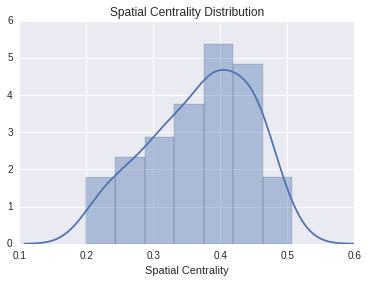

In [67]:
sns.distplot(cent_d)
plt.title("Spatial Centrality Distribution")
plt.xlabel("Spatial Centrality")

In [68]:
weights = G_w.degree(weight='weight')
X = []
for n in used_nodes:
    X.append(weights[n])

Y = cent_d

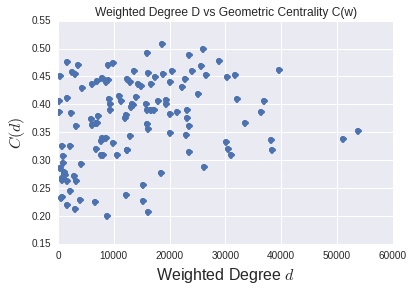

In [69]:
%matplotlib inline
fig = plt.figure(figsize=(6,4))
plt.plot(X, Y, marker='o', linestyle='none')
plt.xlabel(r"Weighted Degree $d$", fontsize=16)
plt.ylabel(r"$C(d)$", fontsize=16)
plt.title("Weighted Degree D vs Geometric Centrality C(w)")
plt.show()

In [70]:
groups = {}
for k, v in partition.iteritems():
    if v in groups:
        groups[v].append(k)
    else:
        groups[v] = [k]
        
print len(groups)

import operator
sorted_space = sorted(space.items(), key=operator.itemgetter(1))  

4


In [71]:
X = []
Y = []

for k in space:
    X.append(cent_w[k])
    Y.append(space[k])

### Closeness Centrality vs Geometric Centrality

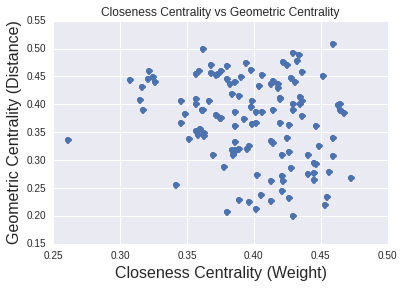

In [72]:
%matplotlib inline
fig = plt.figure(figsize=(6,4))
plt.plot(X, Y, marker='o', linestyle='none')
plt.xlabel(r"Closeness Centrality (Weight)", fontsize=16)
plt.ylabel(r"Geometric Centrality (Distance)", fontsize=16)
plt.title("Closeness Centrality vs Geometric Centrality")
plt.show()

In [73]:
for k in space:
    if space[k] < 0.35 and cent_w[k] < 0.3:
        print k
        

53


### Explanation

Geometric Centrality is defined as:

C_i = (n) / sum(d_ij, from j = 1 to n)

Lower both of them are, the more central.

## Distance Normalized Modularity

We attempt to normalize edge weights by distance, to give us a more spatial invariant measure of things.

In [81]:
S = G_w.copy()

for n in [63, 143, 144, 145]:
    S.remove_node(n)

for u in S:
    for v in S:
        if S.has_edge(u, v):
            S[u][v]['rides'] = S[u][v]['weight']
            if u == v:
                norm = S[u][v]['rides']
            else:
                norm = S[u][v]['rides'] / S[u][v]['distance']
            S[u][v]['weight'] = norm

In [82]:
degree_dict = S.degree(weight='weight')

d_min = min(degree_dict.values())
d_max = max(degree_dict.values())

def norm(x):
    return (float(x) - d_min) / (d_max - d_min)

size_dict = {}

for k in degree_dict:
    size_dict[k] = max(50, 1000 * norm(degree_dict[k]))

## Spatially Normalized Network Structure

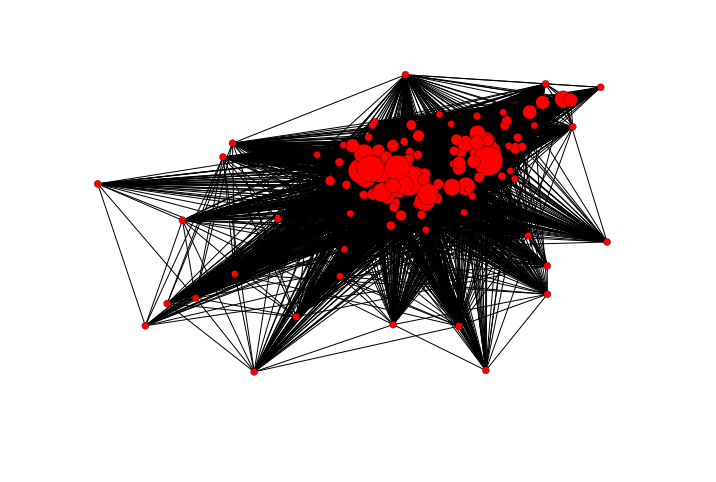

In [86]:
%matplotlib inline
pos = nx.spring_layout(S, weight='weight')
plt.figure(figsize=(12,8))
nx.draw_networkx_edges(S, pos=pos)
nx.draw_networkx_nodes(S, pos=pos, node_size=size_dict.values())

limits = plt.axis('off')

### Most and Least used stations normalized by geometric distances

In [87]:
import operator
sorted_degrees = sorted(S.degree(weight='weight').items(), key=operator.itemgetter(1))

n = len(sorted_degrees)
print "Top 5 used stations"
print "-------------------"
for i in reversed(range(n - 5, n)):
    node_id = sorted_degrees[i][0]
    degree = sorted_degrees[i][1]
    print "Node: {}, Degree: {}, Attributes: {}".format(node_id, degree, G.node[node_id])

print
print
print "Top 5 Least used stations"
print "-------------------------"
for i in range(0, 5):
    node_id = sorted_degrees[i][0]
    degree = sorted_degrees[i][1]
    print "Node: {}, Degree: {}, Attributes: {}".format(node_id, degree, G.node[node_id])

Top 5 used stations
-------------------
Node: 67, Degree: 70482.1067696, Attributes: {'status': 'Existing', 'municipal': 'Cambridge', 'terminal': 'M32006', 'station': 'MIT at Mass Ave / Amherst St', 'lat': '42.3581', 'lng': '-71.093198'}
Node: 58, Degree: 66468.5797352, Attributes: {'status': 'Existing', 'municipal': 'Boston', 'terminal': 'D32017', 'station': 'The Esplanade - Beacon St. at Arlington St.', 'lat': '42.355596', 'lng': '-71.07278'}
Node: 70, Degree: 62284.9792326, Attributes: {'status': 'Existing', 'municipal': 'Cambridge', 'terminal': 'M32016', 'station': 'Harvard Kennedy School at Bennett St / Eliot St', 'lat': '42.372244', 'lng': '-71.121851'}
Node: 114, Degree: 49576.9496466, Attributes: {'status': 'Existing', 'municipal': 'Boston', 'terminal': 'D32022', 'station': 'TD Garden - Causeway at Portal Park #1', 'lat': '42.365942', 'lng': '-71.060515'}
Node: 33, Degree: 45413.9544701, Attributes: {'status': 'Existing', 'municipal': 'Boston', 'terminal': 'B32010', 'station': 

In [88]:
partition = community.best_partition(S)

In [90]:
groups = {}
for k, v in partition.iteritems():
    if v in groups:
        groups[v].append(k)
    else:
        groups[v] = [k]
        
print "There are %i communities" % len(groups)

There are 10 communities


### Spatially Normalized Communities

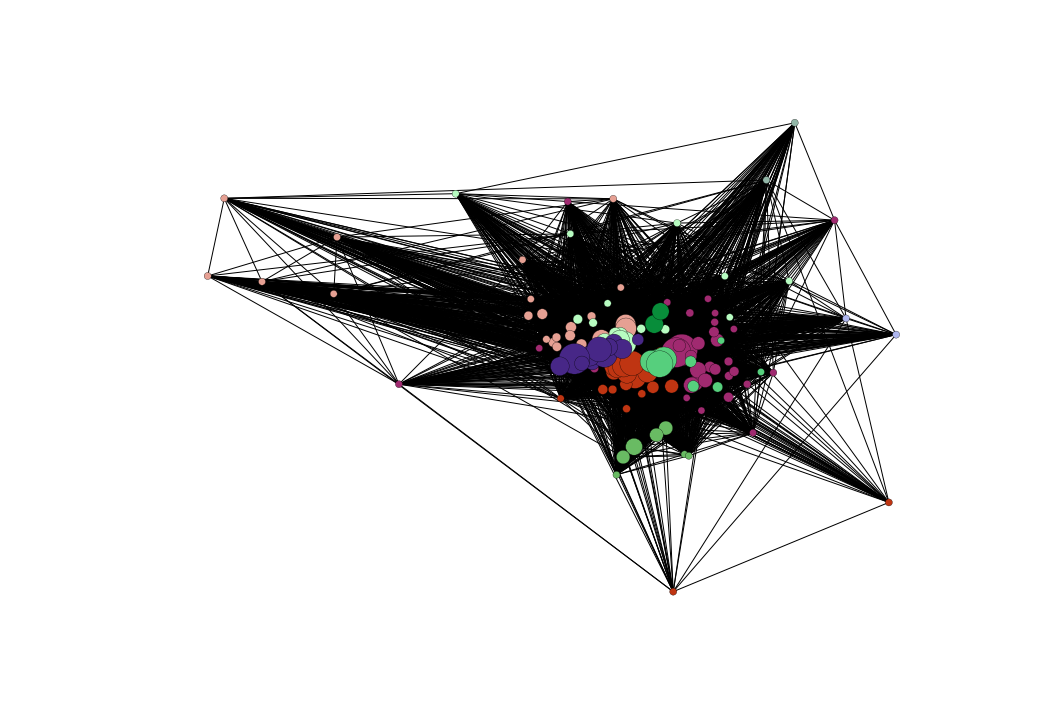

In [91]:
%matplotlib inline

pos = nx.spring_layout(S)
plt.figure(figsize=(18,12))
nx.draw_networkx_edges(S, pos=pos)
for i, group in enumerate(groups):
    sizes = [size_dict[x] for x in groups[group]]
    nx.draw_networkx_nodes(S, pos=pos, nodelist=groups[group], 
                     node_color=np.random.rand(3, 1), node_size=sizes)

limits = plt.axis('off')

#### Degree Distribution (of spatially normalized weights)

In [93]:
bin_edges = np.logspace(np.log10(kmin), np.log10(kmax), num=40)
density, _ = np.histogram(degrees, bins=bin_edges, density=True)

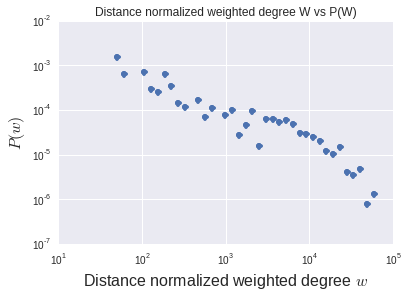

In [94]:
%matplotlib inline
fig = plt.figure(figsize=(6,4))
plt.loglog(bin_edges[:-1], density, marker='o', linestyle='none')
plt.xlabel(r"Distance normalized weighted degree $w$", fontsize=16)
plt.ylabel(r"$P(w)$", fontsize=16)
plt.title("Distance normalized weighted degree W vs P(W)")
plt.show()

Still appears Powerlaw. Testing below using fit_powerlaw function from above

In [96]:
# if False'd out because Powerlaw lib spams out warning
if False:
    pvals = []
    for _ in xrange(50):
        pl = fit_powerlaw(np.array(S.degree(weight='weight').values()))
        pvals.append(pl['pval'])

print "Average p: {}".format(sum(pvals)/ len(pvals))

Average p: 0.586589850881


Null hypothesis is that it is a powerlaw. Can't reject that because the P-Value is too high

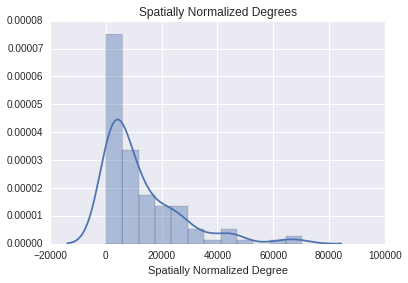

In [98]:
sns.distplot(S.degree(weight='weight').values())
plt.title("Spatially Normalized Degrees")
plt.xlabel("Spatially Normalized Degree")

In [99]:
R = S.copy()

giant_len = len(max(nx.connected_components(R), key=len))
giant_lens = [giant_len]

### Network Robustness: Spatial Centrality Attack

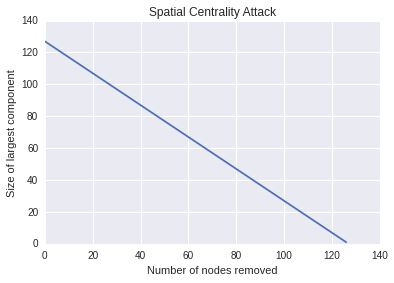

In [103]:
space_c = dict(space)

while(True):
    max_node_id = max(space_c, key=space_c.get)
    R.remove_node(max_node_id)
    del space_c[max_node_id]
    
    if len(R.nodes()) <= 0:
        break
    
    conn = nx.connected_components(R)
    giant_len = len(max(conn, key=len))
    giant_lens.append(giant_len)

%matplotlib inline
plt.plot(range(0, len(giant_lens)), giant_lens)
plt.title("Spatial Centrality Attack")
plt.xlabel("Number of nodes removed")
plt.ylabel("Size of largest component")

Network is also super robust against this attack.

## Null Model

Attempt to compare this to a generic model where we shuffle the weights randomly.

In [104]:
N = G_w.copy()

In [105]:
edg = N.edges(data=True)
weights = []

for e in edg:
    weights.append(e[2]['weight'])

weights = np.array(weights)
np.random.shuffle(weights)
print weights

[ 2 10 24 ..., 20 73 23]


In [106]:
i = 0
for e in N.edges_iter():
    N[e[0]][e[1]]['weight'] = weights[i]
    i+= 1

In [107]:
coeff = nx.clustering(N, weight='weight')
degree = N.degree(weight='weight')

X = degree.values()
Y = coeff.values()

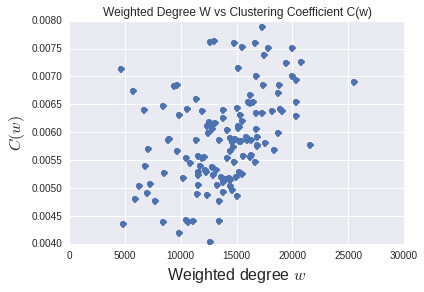

In [108]:
%matplotlib inline
fig = plt.figure(figsize=(6,4))
plt.plot(X, Y, marker='o', linestyle='none')
plt.xlabel(r"Weighted degree $w$", fontsize=16)
plt.ylabel(r"$C(w)$", fontsize=16)
plt.title("Weighted Degree W vs Clustering Coefficient C(w)")
plt.show()

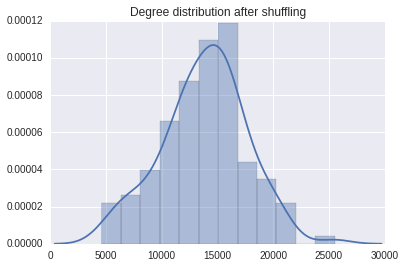

In [109]:
sns.distplot(X)
plt.title("Degree distribution after shuffling")

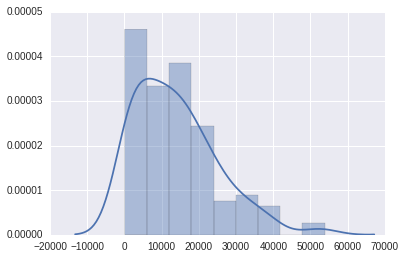

In [110]:
sns.distplot(G_w.degree(weight='weight').values())

This basically just tells us that the distributions of weights we saw earlier are non-random, which totally makes sense. Riding habbits are likely influenced by commute routes, sight-seeing, and general location.

# THE END

Sort of. There are slides somewhere with some more pretty pictures and a few more visualizations if you really, really want more of this...